In [241]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import shutil
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
import torchvision
from torchvision import transforms
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from skimage import color

## Loading Dataset and Extracting Datapoints

In [242]:
data = pd.read_csv("S&P500.csv")
data["Date"] = pd.to_datetime(data["Date"])
stock_data = data[["Close", "S&P 500 PE Ratio"]].values
dates_data = data[ ['Date']].values
scaled_data = MinMaxScaler(feature_range = (0, 1)).fit_transform(stock_data)
data

,Date,Open,High,Low,Close,Adj Close,Volume,S&P 500 PE Ratio
0,1960-01-04,59.91,59.91,59.91,59.91,59.91,3990000,17.055161
1,1960-01-05,60.39,60.39,60.39,60.39,60.39,3710000,17.033548
2,1960-01-06,60.13,60.13,60.13,60.13,60.13,3730000,17.011935
3,1960-01-07,59.69,59.69,59.69,59.69,59.69,3310000,16.990323
4,1960-01-08,59.50,59.50,59.50,59.50,59.50,3290000,16.968710
...,...,...,...,...,...,...,...,...
15602,2021-12-27,4733.99,4791.49,4733.99,4791.19,4791.19,2264120000,28.820000
15603,2021-12-28,4795.49,4807.02,4780.04,4786.35,4786.35,2217050000,29.120000
15604,2021-12-29,4788.64,4804.06,4778.08,4793.06,4793.06,2369370000,29.420000
15605,2021-12-30,4794.23,4808.93,4775.33,4778.73,4778.73,2390990000,29.720000


## Overlay of S&P500 data on Schiller P/E

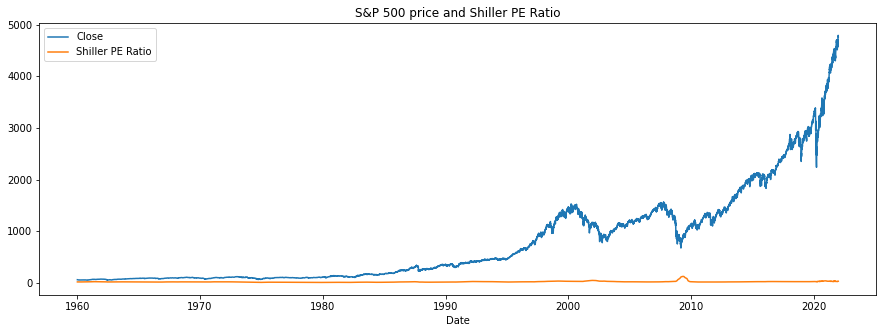

In [243]:
plt.figure(figsize=(15, 5))
plt.plot(data.Date, data.Close.values, label='Close')
plt.plot(data.Date, data['S&P 500 PE Ratio'], label='Shiller PE Ratio')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

## Correlation-based Algorithm Analysis

In [244]:
stock_data = np.append(stock_data, np.zeros([len(stock_data),1]),1)
window_size = 180
for i in range(window_size-1 ,len(stock_data)):
    x = stock_data[(i-window_size+1):(i+1), 0]
    y = stock_data[(i-window_size+1):(i+1), 1]
    r = np.corrcoef(x, y)
    stock_data[i][2] = r[0,1] 
stock_data

array([[ 5.99100000e+01,  1.70551613e+01,  0.00000000e+00],
       [ 6.03900000e+01,  1.70335484e+01,  0.00000000e+00],
       [ 6.01300000e+01,  1.70119355e+01,  0.00000000e+00],
       ...,
       [ 4.79306000e+03,  2.94200000e+01, -3.65033661e-01],
       [ 4.77873000e+03,  2.97200000e+01, -3.48296689e-01],
       [ 4.76618000e+03,  3.00200000e+01, -3.31531916e-01]])

##### Generating SELL signals for S&P 500 data based on Correlation-based Algorithm (Assuming we have $1 Million)

Text(0, 0.5, 'Money in millions')

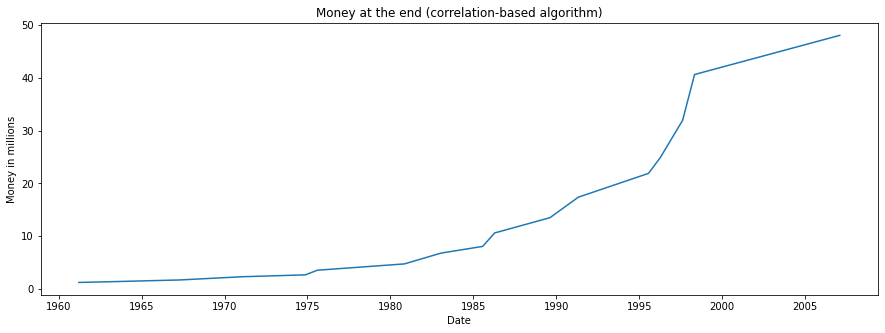

In [245]:
value = 1
money_data = []
trade_data = []
check_sell = 0
for i in range(window_size-1, stock_data.shape[0]):
    correlation_val = stock_data[i,2]
    value_t = stock_data[(i-window_size+1):(i+1), 0]
    if correlation_val > 0.95 and (i-check_sell > window_size):
        bought_value = min(value_t)
        if bought_value > 0:           
            selling_value = value_t[len(value_t)-1]
            value = selling_value/bought_value*value
            check_sell = i 
            money_data.append(value)
            trade_data.append(i)
plt.figure(figsize=(15, 5))
plt.plot(data.Date.loc[trade_data], money_data)
plt.title('Money at the end (correlation-based algorithm)')
plt.xlabel('Date')
plt.ylabel('Money in millions')

In [246]:
# Storing the correlation data for future reference
scaled_data = np.append(scaled_data, np.zeros([len(stock_data),1]),1)
for i in range(window_size-1 ,len(scaled_data)):
    temp = np.corrcoef(scaled_data[(i-window_size+1):(i+1), 0], scaled_data[(i-window_size+1):(i+1), 1])
    scaled_data[i][2] = temp[0,1]
scaled_data

array([[ 0.00162629,  0.08778144,  0.        ],
       [ 0.00172753,  0.08759662,  0.        ],
       [ 0.00167269,  0.0874118 ,  0.        ],
       ...,
       [ 1.        ,  0.19351804, -0.36503366],
       [ 0.99697734,  0.19608346, -0.34829669],
       [ 0.99433014,  0.19864888, -0.33153192]])

## Finding ABCD patterns in S&P 500 data

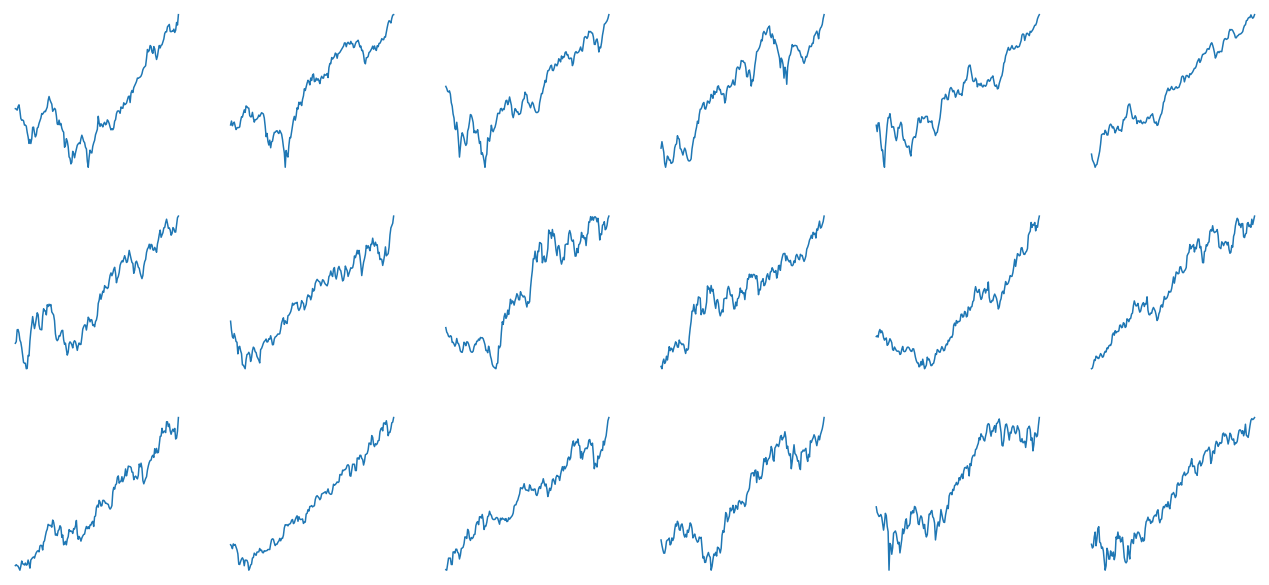

<Figure size 576x576 with 0 Axes>

In [247]:
# Plotting Sell signals
previous_val = 0
sell_signals = []
for x in range(window_size-1, len(scaled_data)):
    if scaled_data[x][2] > 0.95 and x >= previous_val+window_size//3 and \
    scaled_data[x][0] == max(scaled_data[(x-window_size+1):(x+1), 0]) and \
    scaled_data[x][0] > scaled_data[x+1][0]:
        sell_signals.append(x)
        previous_val = x

previous_val = 0
dont_sell_signals = []
for x in range(window_size-1,len(scaled_data)):
    if scaled_data[x][2] < 0.5  and x >= previous_val+window_size//3 and \
    scaled_data[x][0] < max(scaled_data[(x-window_size+1):(x+1), 0]):
        dont_sell_signals.append(x)
        previous_val = x
        
fig, ax = plt.subplots(3,6)
fig.set_size_inches(22.5, 10.5, forward=True)

row = 0
col = 0
for signal in sell_signals:
    close_price_data = []
    for i in reversed(range(0, window_size)):
        close_price_data.append(scaled_data[signal-i][0])        
    if col%6==0 and col !=0:
        row += 1
        col = 0
    img_name = f"day{signal}.png"
    ax[row, col].plot(close_price_data)
    ax[row, col].axis("off")
    extent = ax[row,col].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("sell_images_data/" + img_name, bbox_inches=extent, pad_inches=0, dpi = 100)
    col += 1
plt.show()
plt.clf()

for signal in dont_sell_signals:
    close_price_data = []
    for i in reversed(range(0, window_size)):
        close_price_data.append(scaled_data[signal-i][0])
    if col%6==0 and col !=0:
        row += 1
        col = 0
    img_name = f"day{signal}.png"
    plt.axis('off')
    plt.plot(close_price_data)
    f = plt.gcf()
    f.set_size_inches(8, 8)
    plt.savefig("hold_images_data/" + img_name, bbox_inches='tight', pad_inches=0, dpi = 100)
    plt.clf()

##### Using ABCD patterns to generate training data

In [248]:
images_training_set = []
for i in tqdm(sell_signals):
    image_data = imread(f"sell_images_data/day{i}.png", as_gray=True)    
    image_data = resize(image_data, (180, 180), anti_aliasing=True)
    images_training_set.append(image_data.astype('float32'))
y_train = np.repeat(1, len(sell_signals))
for i in tqdm(dont_sell_signals):
    image_data = imread(f"hold_images_data/day{i}.png", as_gray=True)
    image_data = resize(image_data, (180, 180), anti_aliasing=True)
    images_training_set.append(image_data.astype('float32'))
y_train = np.append(y_train, np.repeat(0, len(dont_sell_signals)))  
X_train = np.array(images_training_set)

100%|██████████| 118/118 [00:07<00:00, 15.13it/s]


In [249]:
# fig, axs = plt.subplots(1, 10 ,figsize=(20,20))
# for i, ax in enumerate(axs.flatten()):
#     ax.imshow(X_train[i], cmap='gray', vmin=0, vmax=1)
#     ax.axis('off')
# plt.show()

## CNN Model

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state=0)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
y_train = y_train.astype(dtype=np.int64)
X_train  = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
X_test  = torch.from_numpy(X_test)
y_test = y_test.astype(dtype=np.int64)
y_test = torch.from_numpy(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([108, 1, 180, 180]),
 torch.Size([108]),
 torch.Size([28, 1, 180, 180]),
 torch.Size([28]))

##### Generating model

In [251]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(8100, 2)
        )
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)      
        x = self.linear_layers(x)
        return x
        
training_loss_data = []
training_accuracy_data = []
valuation_loss_data = []
valuation_accuracy_data = []

def train(epoch):
    model.train()
    tr_loss = 0
    train_X, train_y = Variable(X_train), Variable(y_train)
    test_X, test_y = Variable(X_test), Variable(y_test)
    if torch.cuda.is_available():
        train_X = train_X.cuda()
        train_y = train_y.cuda()
        test_X = test_X.cuda()
        test_y = test_y.cuda()
    optimizer.zero_grad()
    output_train = model(train_X)
    output_val = model(test_X)
    loss_train = criterion(output_train, train_y)
    loss_val = criterion(output_val, test_y)
    training_loss_data.append(loss_train)
    valuation_loss_data.append(loss_val)

    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%5 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    with torch.no_grad():
        output = model(X_train)

    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    training_accuracy_data.append(accuracy_score(y_train, predictions))
    with torch.no_grad():
        output = model(X_test)
    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    valuation_accuracy_data.append(accuracy_score(y_test, predictions))
    
    countHold = sum(np.logical_and(predictions == 0, y_test.numpy() == 0))
    countSell = sum(np.logical_and(predictions == 1, y_test.numpy() == 1))
    
    accuracyhold = countHold/sum(y_test == 0)
    accuracysell = countSell/sum(y_test == 1)
    if epoch%5 == 0:
        print('Epoch: ', epoch+1,  '| Hold/Sell accuracy: %.2f/%.2f' %(accuracyhold, accuracysell))

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
model = Net()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=8100, out_features=2, bias=True)
  )
)


In [252]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
for epoch in range(40):
    train(epoch)

Epoch :  1 	 loss : tensor(0.8624, grad_fn=<NllLossBackward0>)
Epoch:  1 | Hold/Sell accuracy: 1.00/0.00
Epoch :  6 	 loss : tensor(0.3748, grad_fn=<NllLossBackward0>)
Epoch:  6 | Hold/Sell accuracy: 0.92/0.33
Epoch :  11 	 loss : tensor(0.2856, grad_fn=<NllLossBackward0>)
Epoch:  11 | Hold/Sell accuracy: 0.92/0.67
Epoch :  16 	 loss : tensor(0.4158, grad_fn=<NllLossBackward0>)
Epoch:  16 | Hold/Sell accuracy: 1.00/0.33
Epoch :  21 	 loss : tensor(0.4420, grad_fn=<NllLossBackward0>)
Epoch:  21 | Hold/Sell accuracy: 1.00/0.33
Epoch :  26 	 loss : tensor(0.2716, grad_fn=<NllLossBackward0>)
Epoch:  26 | Hold/Sell accuracy: 1.00/0.33
Epoch :  31 	 loss : tensor(0.2108, grad_fn=<NllLossBackward0>)
Epoch:  31 | Hold/Sell accuracy: 1.00/0.67
Epoch :  36 	 loss : tensor(0.2011, grad_fn=<NllLossBackward0>)
Epoch:  36 | Hold/Sell accuracy: 0.92/0.67


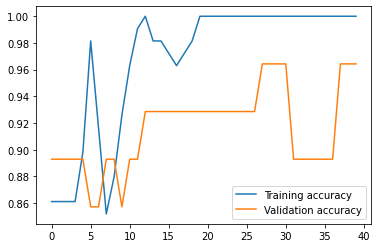

In [253]:
plt.plot(training_accuracy_data, label='Training accuracy')
plt.plot(valuation_accuracy_data, label='Validation accuracy')
plt.legend()
plt.show()

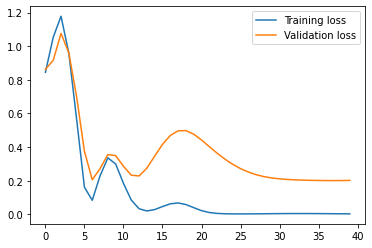

In [254]:
tl = [x.detach().numpy() for x in training_loss_data]
vl = [x.detach().numpy() for x in valuation_loss_data]
plt.plot(tl, label='Training loss')
plt.plot(vl, label='Validation loss')
plt.legend()
plt.show()

In [255]:
#Training data accuracy
with torch.no_grad():
    output = model(X_train)
    
softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(y_train, predictions)

1.0

In [256]:
#Testing data accuracy
with torch.no_grad():
    output = model(X_test)

softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(y_test, predictions)

0.9642857142857143

## Training CNN + RNN models

In [257]:
input_size = 3
output_size = 4
window_size = 180
hidden_size = 16
num_layers = 1
rnn_epochs = 100
learning_rate = 0.001
n_rows, n_cols = scaled_data.shape
(n_rows, n_cols)
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(scaled_data[i:i+window_size, ])
    y_full.append(scaled_data[i+window_size: i+ window_size + output_size, 0])
    date_full.append(dates_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

##### RNN Model

In [258]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

all_img = []
for i in range(X_full.shape[0]):  
    x = X_full[i,:, 0] 
    plt.axis('off')
    plt.plot(x, color ="black") 
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    figure.canvas.draw()
       
    width, height = figure.get_size_inches() * figure.get_dpi()
    mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    gray_image = color.rgb2gray(mplimage)
    img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
    img_resize = img_resize.astype('float32')
    plt.clf()   
    all_img.append(img_resize)
    
all_x = np.array(all_img)
all_x.shape

(15424, 180, 180)

<Figure size 576x576 with 0 Axes>

In [259]:
stock_data = data[["Close", "S&P 500 PE Ratio"]].values
stock_data = np.append(stock_data, np.zeros([len(stock_data),1]),1)
stock_data.shape
x_image_data = all_x
x_image_data = x_image_data.reshape(x_image_data.shape[0], 1, x_image_data.shape[1], x_image_data.shape[2])
x_image_data = torch.from_numpy(x_image_data)
x_image_data.shape

torch.Size([15424, 1, 180, 180])

In [260]:
with torch.no_grad():
    output = model(x_image_data)
softmax = torch.exp(output)
prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis = 1)
for i in range( len(prob)):
    stock_data[i+ window_size, 2] = prob[i]
msci = MinMaxScaler(feature_range = (0, 1))
scaled_data = msci.fit_transform(stock_data)
scaled_data

array([[0.00162629, 0.08778144, 0.        ],
       [0.00172753, 0.08759662, 0.        ],
       [0.00167269, 0.0874118 , 0.        ],
       ...,
       [1.        , 0.19351804, 0.        ],
       [0.99697734, 0.19608346, 0.        ],
       [0.99433014, 0.19864888, 0.        ]])

In [261]:
X_complete = []
y_complete = []
dates_complete = []
for i in range(window_size , n_rows - window_size - output_size +1):
    X_complete.append(scaled_data[i:i+window_size, ])
    y_complete.append(scaled_data[i+window_size: i+ window_size + output_size, 0])
    dates_complete.append(dates_data[i+window_size])
    
X_complete, y_complete, dates_complete = np.array(X_complete), np.array(y_complete), np.array(date_full)
y_complete = np.reshape(y_complete, (y_complete.shape[0], 1, y_complete.shape[1]))

##### Generating training data for RNN model

In [262]:
X_train = []
y_train = []
date_train = []
X_val = []
y_val = []
date_val = []
X_test = []
y_test = []
date_test = []
for i in range(X_complete.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_complete[i])
        y_test.append(y_complete[i])
        date_test.append(dates_complete[i])
    elif (i % 253 < 160):
        X_train.append(X_complete[i])
        y_train.append(y_complete[i])
        date_train.append(dates_complete[i])
    else:
        X_val.append(X_complete[i])
        y_val.append(y_complete[i])
        date_val.append(dates_complete[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train) 
X_val, y_val, date_val = np.array(X_val), np.array(y_val), np.array(date_val) 
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)     

In [263]:
X_test.shape

(3180, 180, 3)

In [264]:
output_data = np.concatenate((y_train[:, 0, [0]], y_train[:, 0, [0]], y_train[:, 0, [0]]), axis=1)
stock_price_training_data = msci.inverse_transform(output_data)[:, [0]]
output_data = np.concatenate((y_val[:, 0, [0]], y_val[:, 0, [0]], y_val[:, 0, [0]]), axis=1)
stock_price_validation_data = msci.inverse_transform(output_data)[:, [0]]
output_data = np.concatenate((y_test[:, 0, [0]], y_test[:, 0, [0]], y_test[:, 0, [0]]), axis=1)
stock_price_testing_data = msci.inverse_transform(output_data)[:, [0]]

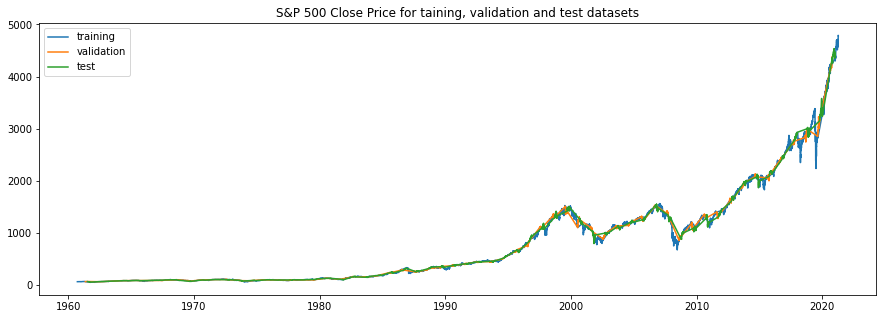

In [265]:
plt.figure(figsize=(15, 5))
plt.plot(date_train, stock_price_training_data[:,0],label = 'training')
plt.plot(date_val, stock_price_validation_data[:,0], label = 'validation')
plt.plot(date_test, stock_price_testing_data[:,0], label = 'test')
plt.title('S&P 500 Close Price for taining, validation and test datasets')
plt.legend()
plt.show()

In [266]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
rnn_model = RNN(input_size, output_size, hidden_size, num_layers)
optimiser_rnn = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
rnn_model

RNN(
  (rnn): RNN(3, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

##### Training RNN model

In [267]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
all_data_loss = []
all_data_loss_valuation = []
for epoch in range(rnn_epochs):
    ip = Variable(torch.from_numpy(X_train).float())
    l = Variable(torch.from_numpy(y_train).float())
    optimiser_rnn.zero_grad()
    output, hidden = rnn_model(ip) 
    loss = loss_function(output.reshape(-1), l.view(-1))
    all_data_loss += [loss.item()]
    loss.backward(retain_graph=True)
    ip_val = torch.from_numpy(X_val).float()
    l_val = torch.from_numpy(y_val).float()
    output_val, hidden_val = rnn_model(ip_val)
    loss_val = loss_function(output_val.reshape(-1), l_val.view(-1))
    all_data_loss_valuation += [loss_val.item()]
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "loss : ", loss.item())
    optimiser_rnn.step()

Epoch  0 loss :  0.12173143774271011
Epoch  10 loss :  0.07677026838064194
Epoch  20 loss :  0.05001276358962059
Epoch  30 loss :  0.03672443702816963
Epoch  40 loss :  0.03346620500087738
Epoch  50 loss :  0.03196157515048981
Epoch  60 loss :  0.029887016862630844
Epoch  70 loss :  0.028040269389748573
Epoch  80 loss :  0.025920499116182327
Epoch  90 loss :  0.023313766345381737


In [268]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], output.detach().numpy()[:, [0]], output.detach().numpy()[:, [0]]), axis=1)
predicted_price = msci.inverse_transform(out_temp)[:, [0]]
predicted_price

array([[1054.6266],
       [1055.7688],
       [1056.3477],
       ...,
       [1522.9619],
       [1519.0935],
       [1532.5614]], dtype=float32)

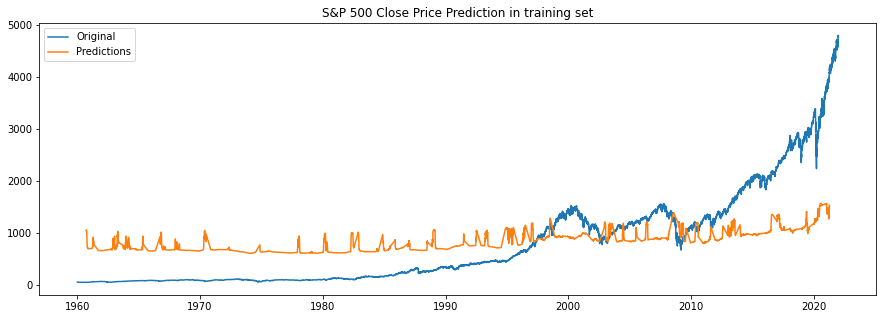

In [269]:
plt.figure(figsize=(15, 5))
plt.plot(data.Date, stock_data[:,0], label = 'Original')
plt.plot(date_train, predicted_price, label = 'Predictions')
plt.title('S&P 500 Close Price Prediction in training set')
plt.legend()
plt.show()

In [270]:
def claculuatePredicitionError(target, pred):
    error = abs(pred - target)/target
    return error
# Predicitions for T+1
output_data = np.concatenate( (y_train[:, :, 0], y_train[:, :, 0], y_train[:, :, 0]), axis = 1)
train_target_data = msci.inverse_transform(output_data)[:, [0]]
error_t1 = claculuatePredicitionError(train_target_data, predicted_price)

# Predicitions for T+2
train_inputs_t2 = Variable(torch.from_numpy(X_train).float())
train_t2, _ = rnn_model(train_inputs_t2)
output_data = np.concatenate((train_t2.detach().numpy()[:, [1]], train_t2.detach().numpy()[:, [1]], train_t2.detach().numpy()[:, [1]]), axis=1)
predicitons_t2 = msci.inverse_transform(output_data)[:, [0]]
output_data = np.concatenate( (y_train[:, :, 1], y_train[:, :, 1], y_train[:, :, 1]), axis = 1)
train_target_data = msci.inverse_transform(output_data)[:, [0]]
error_t2 = claculuatePredicitionError(train_target_data, predicitons_t2)

# Predicitions for T+3
output_data = np.concatenate((train_t2.detach().numpy()[:, [2]], train_t2.detach().numpy()[:, [2]], train_t2.detach().numpy()[:, [2]]), axis=1)
predicitons_t3 = msci.inverse_transform(output_data)[:, [0]]
output_data = np.concatenate( (y_train[:, :, 2], y_train[:, :, 2], y_train[:, :, 2]), axis = 1)
train_target_data = msci.inverse_transform(output_data)[:, [0]]
error_t3 = claculuatePredicitionError(train_target_data, predicitons_t3)

# Predicitions for T+4
output_data = np.concatenate((train_t2.detach().numpy()[:, [3]], train_t2.detach().numpy()[:, [3]], train_t2.detach().numpy()[:, [3]]), axis=1)
predicitons_t4 = msci.inverse_transform(output_data)[:, [0]]
output_data = np.concatenate( (y_train[:, :, 3], y_train[:, :, 3], y_train[:, :, 3]), axis = 1)
train_target_data = msci.inverse_transform(output_data)[:, [0]]
error_t4 = claculuatePredicitionError(train_target_data, predicitons_t4)

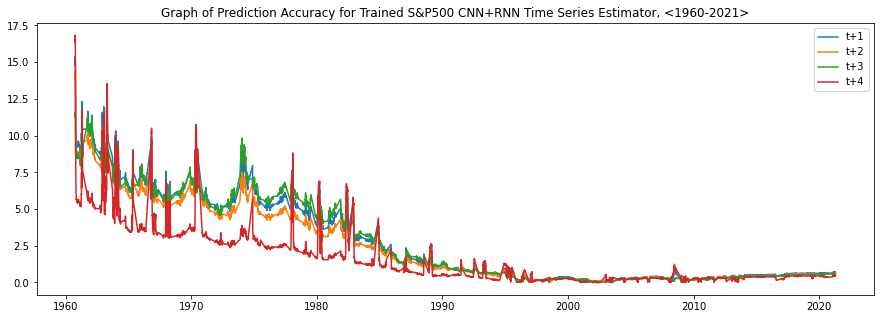

In [271]:
plt.figure(figsize=(15, 5))
plt.plot(date_train, error_t1, label = 't+1')
plt.plot(date_train+ pd.Timedelta('1 day'), error_t2, label = 't+2')
plt.plot(date_train+ pd.Timedelta('2 day'), error_t3, label = 't+3')
plt.plot(date_train+ pd.Timedelta('3 day'), error_t4, label = 't+4')
plt.title('Graph of Prediction Accuracy for Trained S&P500 CNN+RNN Time Series Estimator, <1960-2021>')
plt.legend()
plt.show()

## Testing for Dataset 1980-2021

In [272]:
date1980 = np.datetime64("1980-01-01")
date_test_par = date_test[date_test>date1980]
inputs_1980 = Variable(torch.from_numpy(X_test).float())
output_1980, _ = rnn_model(inputs_1980)
out_temp_1980 = np.concatenate((output_1980.detach().numpy()[:, [0]], output_1980.detach().numpy()[:, [0]], output_1980.detach().numpy()[:, [0]]), axis=1)
predictions_1980 = msci.inverse_transform(out_temp_1980)[:, [0]]
out_temp_1980 = np.concatenate( (y_test[:, :, 0], y_test[:, :, 0], y_test[:, :, 0]), axis = 1)
target_1980 = msci.inverse_transform(out_temp_1980)[:, [0]]
error_t1_1980 = claculuatePredicitionError(target_1980, predictions_1980)
error_t1_final_1980 = error_t1_1980[date_test>date1980]


# Predicitions for T+2
out_temp_1980 = np.concatenate((output_1980.detach().numpy()[:, [1]], output_1980.detach().numpy()[:, [1]], output_1980.detach().numpy()[:, [1]]), axis=1)
predicitons_t2_1980 = msci.inverse_transform(out_temp_1980)[:, [0]]
out_temp_1980 = np.concatenate( (y_test[:, :, 1], y_test[:, :, 1], y_test[:, :, 1]), axis = 1)
train_target_data = msci.inverse_transform(out_temp_1980)[:, [0]]
error_t2_1980 = claculuatePredicitionError(train_target_data, predicitons_t2_1980)
error_t2_final_1980 = error_t2_1980[date_test>date1980]

# # Predicitions for T+3
out_temp_1980 = np.concatenate((output_1980.detach().numpy()[:, [2]], output_1980.detach().numpy()[:, [2]], output_1980.detach().numpy()[:, [2]]), axis=1)
predicitons_t3_1980 = msci.inverse_transform(out_temp_1980)[:, [0]]
out_temp_1980 = np.concatenate( (y_test[:, :, 2], y_test[:, :, 2], y_test[:, :, 2]), axis = 1)
train_target_data = msci.inverse_transform(out_temp_1980)[:, [0]]
error_t3_1980 = claculuatePredicitionError(train_target_data, predicitons_t3_1980)
error_t3_final_1980 = error_t3_1980[date_test>date1980]

# Predicitions for T+4
out_temp_1980 = np.concatenate((output_1980.detach().numpy()[:, [3]], output_1980.detach().numpy()[:, [3]], output_1980.detach().numpy()[:, [3]]), axis=1)
predicitons_t4_1980 = msci.inverse_transform(out_temp_1980)[:, [0]]
out_temp_1980 = np.concatenate( (y_test[:, :, 3], y_test[:, :, 3], y_test[:, :, 3]), axis = 1)
train_target_data = msci.inverse_transform(out_temp_1980)[:, [0]]
error_t4_1980 = claculuatePredicitionError(train_target_data, predicitons_t4_1980)
error_t4_final_1980 = error_t4_1980[date_test>date1980]

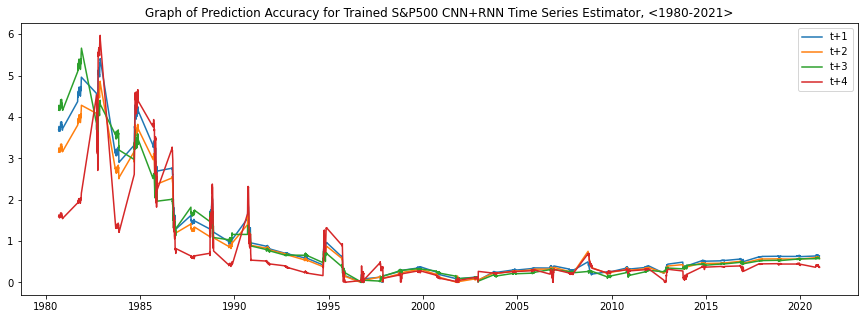

In [273]:
plt.figure(figsize=(15, 5))
plt.plot(date_test_par, error_t1_final_1980, label = 't+1')
plt.plot(date_test_par+ pd.Timedelta('1 day'), error_t2_final_1980, label = 't+2')
plt.plot(date_test_par+ pd.Timedelta('2 day'), error_t3_final_1980, label = 't+3')
plt.plot(date_test_par+ pd.Timedelta('3 day'), error_t4_final_1980, label = 't+4')
plt.title('Graph of Prediction Accuracy for Trained S&P500 CNN+RNN Time Series Estimator, <1980-2021>')
plt.legend()
plt.show()

## Optimizing CNN+RNN model

In [274]:
input_size = 3
hidden_size = 32
num_layers = 2
output_size = 4
num_epochs = 100
learning_rate = 0.005
window_size = 180

X_full = []
y_full = []
date_full = []
for i in range(window_size , n_rows - window_size - output_size +1):
    X_full.append(scaled_data[i:i+window_size, ])
    y_full.append(scaled_data[i+window_size: i+ window_size + output_size, 0])
    date_full.append(dates_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

X_train = []; y_train = []; date_train = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train)          
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
rnn = RNN(input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "loss : ", loss.item())
    optimiser.zero_grad()

    loss.backward(retain_graph=True)
    optimiser.step()

Epoch  0 MSE:  0.06409520655870438
Epoch  10 MSE:  0.00404447503387928
Epoch  20 MSE:  0.0024379121605306864
Epoch  30 MSE:  0.0009362988639622927
Epoch  40 MSE:  0.00035484679392538965
Epoch  50 MSE:  0.00022750493371859193
Epoch  60 MSE:  0.00017315437435172498
Epoch  70 MSE:  0.00013475677405949682
Epoch  80 MSE:  0.00011418676876928657
Epoch  90 MSE:  9.759286331245676e-05


In [275]:
all_inputs = Variable(torch.from_numpy(X_full).float())
output_all, _ = rnn(all_inputs)

# T+1
idx = 0
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = msci.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = msci.inverse_transform(out_temp)[:, [0]]
error_all_1 = claculuatePredicitionError(target_all, predicted_price_all)
predicted_price_all

# T+2
idx = 1
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = msci.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = msci.inverse_transform(out_temp)[:, [0]]
error_all_2 = claculuatePredicitionError(target_all, predicted_price_all)
predicted_price_all

# T+3
idx = 2
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = msci.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = msci.inverse_transform(out_temp)[:, [0]]
error_all_3 = claculuatePredicitionError(target_all, predicted_price_all)
predicted_price_all

# T+4
idx = 3
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = msci.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = msci.inverse_transform(out_temp)[:, [0]]
error_all_4 = claculuatePredicitionError(target_all, predicted_price_all)
predicted_price_all

array([[  66.26578],
       [  66.57902],
       [  66.75471],
       ...,
       [4239.2935 ],
       [4265.38   ],
       [4303.2983 ]], dtype=float32)

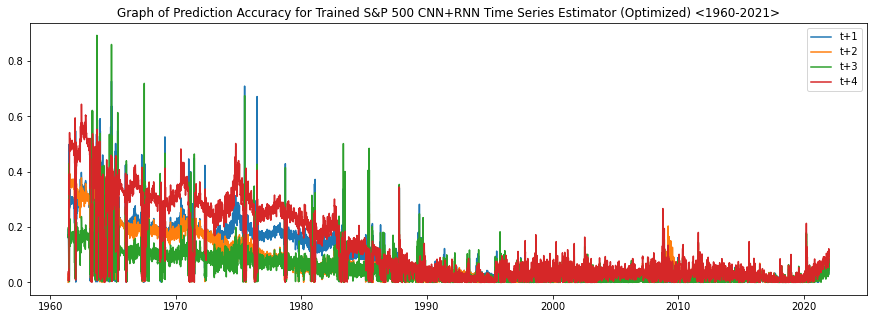

In [276]:
plt.figure(figsize=(15, 5))
plt.plot(date_full, error_all_1, label = 't+1')
plt.plot(date_full+ pd.Timedelta('1 day'), error_all_2, label = 't+2')
plt.plot(date_full+ pd.Timedelta('2 day'), error_all_3, label = 't+3')
plt.plot(date_full+ pd.Timedelta('3 day'), error_all_4, label = 't+4')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized) <1960-2021>')
plt.legend()
plt.show()

## Enhancing CNN+RNN model

Text(0, 0.5, 'Money (millions)')

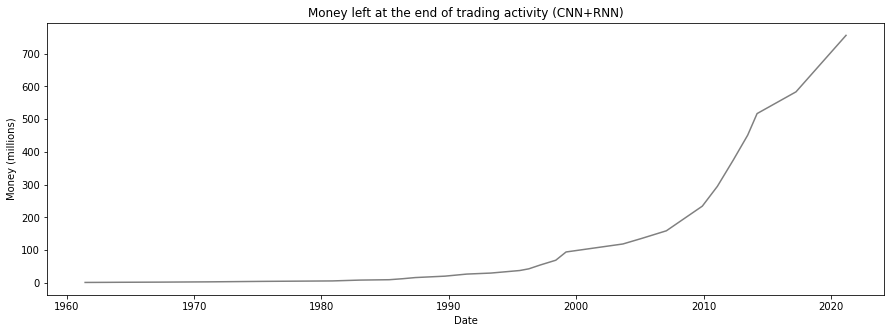

In [277]:
money = 1
money_full = []
trade_full = []
lastselltime = -180
for i in range(1,X_full.shape[0]):
    temp = msci.inverse_transform(X_full[i,:, :])
    prob_temp = temp[:, 2]
    price_temp = temp[:, 0]
    if prob_temp[180-1] > 0.95 and (i-lastselltime > 180):
        buy_price = min(price_temp)
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price*money
            lastselltime = i
            money_full.append(money)
            trade_full.append(i)

plt.figure(figsize=(15, 5))
plt.plot(date_full[trade_full],
         money_full, color='grey', label='Close')
plt.title('Money left at the end of trading activity (CNN+RNN)')
plt.xlabel('Date')
plt.ylabel('Money (millions)')

## Introducing Noise in the Dataset

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-22,0.164553,0.164552,0.164553,0.164553,0.164553,0.164552,0.164552,0.164553,0.164553,0.164553
1980-05-23,0.173455,0.173455,0.173455,0.173455,0.173455,0.173455,0.173455,0.173456,0.173455,0.173455
1980-05-27,0.169938,0.169951,0.169901,0.169874,0.169953,0.170207,0.170209,0.168333,0.172313,0.164184
1980-05-28,0.162468,0.162466,0.162467,0.162471,0.162475,0.162462,0.162539,0.162374,0.162667,0.163023
1980-05-29,0.138367,0.138336,0.138378,0.138687,0.138632,0.138319,0.137554,0.136376,0.135768,0.142722
...,...,...,...,...,...,...,...,...,...,...
2021-09-21,0.032076,0.032076,0.032076,0.032076,0.032076,0.032076,0.032076,0.032076,0.032076,0.032076
2021-09-22,0.048164,0.048164,0.048165,0.048163,0.048163,0.048169,0.048166,0.048184,0.048196,0.048128
2021-09-23,0.062328,0.062331,0.062329,0.062332,0.062339,0.062311,0.062305,0.062306,0.062411,0.062137
2021-09-24,0.060407,0.060407,0.060407,0.060407,0.060407,0.060407,0.060407,0.060407,0.060407,0.060407


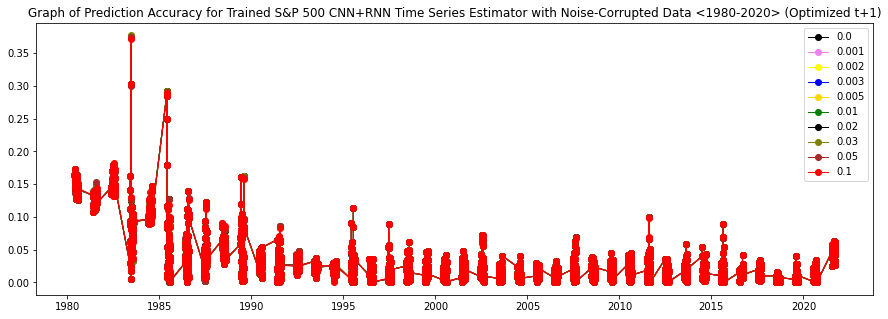

In [278]:
stddev = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
colors = {
        0.001: 'violet',
        0.002: 'yellow',
        0.003: 'blue',
        0.005: 'gold',
        0.01: 'green',
        0.02: 'black',
        0.03: 'olive',
        0.05: 'brown',
        0.1: 'red',
        0.0: 'black'
    }

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i] 
        s = max(X_test[1, index, 0])*s
        temp = dataset_noise[i, index, 0] + s
        temp[temp < 0] = 0.0000001
        dataset_noise[i, index, 0]  = temp        
    return dataset_noise

# Testing data with noisy data
idx = 0
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = msci.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stddev:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = msci.inverse_transform(out_temp)[:, [0]]
    error = claculuatePredicitionError(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_1 = []
for i in range(len(stddev)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_1.append(temp)
labels = date_test_partial
error_df=pd.DataFrame(error_res_all_partial_1, columns=labels, index=stddev).T

# Plotting Noisy predicitions
plt.figure(1, figsize=(15, 5))
for i in range(len(stddev)):    
    plt.plot(date_test_partial, error_res_all_partial_1[i], color=colors[stddev[i]], lw=1, label = stddev[i], marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized t+1)')
plt.legend(loc="upper right")
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-23,0.082204,0.082203,0.082204,0.082204,0.082204,0.082204,0.082204,0.082204,0.082205,0.082204
1980-05-24,0.084613,0.084613,0.084613,0.084613,0.084613,0.084613,0.084614,0.084613,0.084614,0.084613
1980-05-28,0.079867,0.079818,0.079824,0.079918,0.079192,0.079055,0.080669,0.078022,0.081315,0.082515
1980-05-29,0.053566,0.053567,0.053558,0.053557,0.053544,0.053577,0.053564,0.053650,0.053676,0.053792
1980-05-30,0.052476,0.052330,0.052698,0.052439,0.052627,0.052200,0.051177,0.048748,0.053658,0.045048
...,...,...,...,...,...,...,...,...,...,...
2021-09-22,0.052454,0.052454,0.052454,0.052454,0.052454,0.052454,0.052454,0.052454,0.052454,0.052454
2021-09-23,0.069966,0.069966,0.069966,0.069966,0.069965,0.069962,0.069968,0.069974,0.069970,0.069969
2021-09-24,0.072607,0.072607,0.072604,0.072604,0.072605,0.072610,0.072584,0.072617,0.072610,0.072547
2021-09-25,0.065152,0.065153,0.065152,0.065152,0.065153,0.065152,0.065153,0.065152,0.065152,0.065153


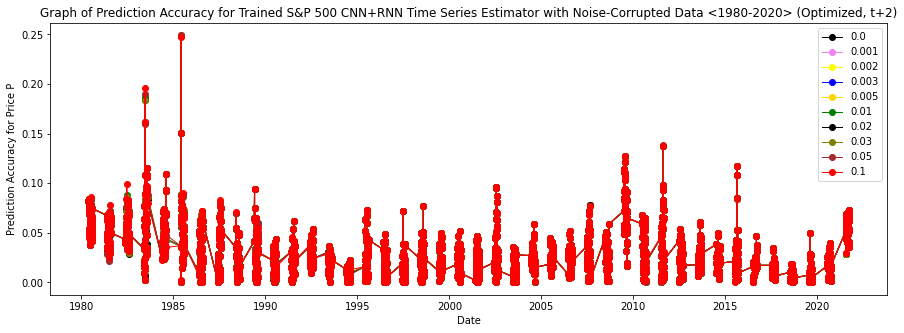

In [279]:
idx = 1
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = msci.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stddev:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = msci.inverse_transform(out_temp)[:, [0]]
    error = claculuatePredicitionError(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_2 = []
for i in range(len(stddev)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_2.append(temp)
labels = date_test_partial + pd.Timedelta('1 day')
error_df=pd.DataFrame(error_res_all_partial_2, columns=labels, index=stddev).T
plt.figure(1, figsize=(15, 5))
for i in range(len(stddev)):    
    plt.plot(date_test_partial+ pd.Timedelta('1 day'), error_res_all_partial_2[i], color=colors[stddev[i]], lw=1, label = stddev[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized, t+2)')
plt.legend(loc="upper right")
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-22,0.094674,0.094674,0.094674,0.094674,0.094674,0.094673,0.094674,0.094673,0.094673,0.094674
1980-05-23,0.095829,0.095829,0.095829,0.095829,0.095829,0.095829,0.095830,0.095829,0.095829,0.095829
1980-05-27,0.071346,0.071344,0.071241,0.071285,0.071504,0.072256,0.071244,0.070807,0.073691,0.073384
1980-05-28,0.068953,0.068954,0.068954,0.068953,0.068953,0.068952,0.068947,0.068952,0.068938,0.069001
1980-05-29,0.055100,0.055196,0.055105,0.055069,0.055050,0.055528,0.056079,0.058721,0.054538,0.049857
...,...,...,...,...,...,...,...,...,...,...
2021-09-21,0.047796,0.047796,0.047796,0.047796,0.047796,0.047796,0.047796,0.047796,0.047796,0.047796
2021-09-22,0.055395,0.055395,0.055395,0.055396,0.055395,0.055400,0.055389,0.055397,0.055402,0.055423
2021-09-23,0.054102,0.054100,0.054098,0.054098,0.054095,0.054110,0.054099,0.054088,0.054164,0.054391
2021-09-24,0.029285,0.029285,0.029285,0.029285,0.029285,0.029285,0.029285,0.029285,0.029285,0.029286


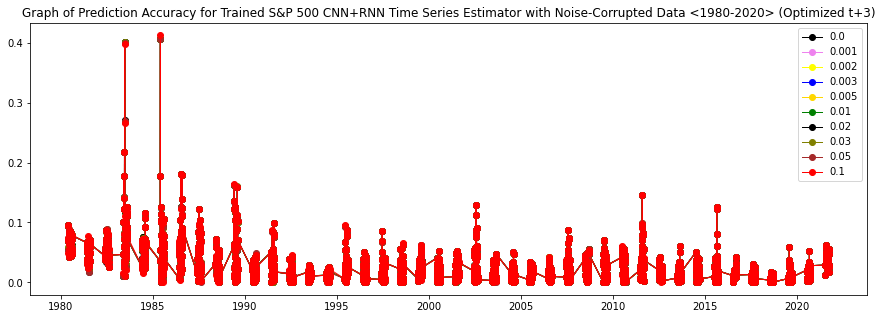

In [280]:
idx = 2
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = msci.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stddev:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = msci.inverse_transform(out_temp)[:, [0]]
    error = claculuatePredicitionError(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_1 = []
for i in range(len(stddev)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_1.append(temp)
labels = date_test_partial
error_df=pd.DataFrame(error_res_all_partial_1, columns=labels, index=stddev).T

# Plotting Noisy predicitions
plt.figure(1, figsize=(15, 5))
for i in range(len(stddev)):    
    plt.plot(date_test_partial, error_res_all_partial_1[i], color=colors[stddev[i]], lw=1, label = stddev[i], marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized t+3)')
plt.legend(loc="upper right")
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-22,0.252964,0.252964,0.252963,0.252964,0.252963,0.252963,0.252963,0.252963,0.252964,0.252964
1980-05-23,0.236062,0.236061,0.236061,0.236061,0.236062,0.236062,0.236063,0.236061,0.236061,0.236062
1980-05-27,0.231777,0.231802,0.231662,0.231727,0.232002,0.232151,0.229311,0.230411,0.236447,0.242636
1980-05-28,0.216037,0.216032,0.216036,0.216041,0.216041,0.216110,0.215814,0.215689,0.216196,0.216441
1980-05-29,0.204412,0.204399,0.204431,0.204150,0.204407,0.204424,0.204156,0.204226,0.202332,0.190560
...,...,...,...,...,...,...,...,...,...,...
2021-09-21,0.084557,0.084557,0.084557,0.084557,0.084557,0.084557,0.084557,0.084557,0.084557,0.084557
2021-09-22,0.087755,0.087755,0.087755,0.087754,0.087754,0.087755,0.087751,0.087761,0.087755,0.087764
2021-09-23,0.068902,0.068904,0.068903,0.068904,0.068911,0.068870,0.068892,0.068970,0.068856,0.068939
2021-09-24,0.065254,0.065254,0.065254,0.065254,0.065254,0.065254,0.065254,0.065254,0.065254,0.065254


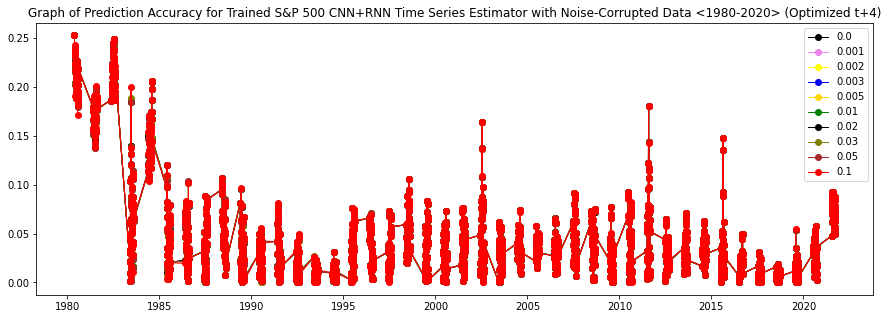

In [281]:
idx = 3
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = msci.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stddev:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = msci.inverse_transform(out_temp)[:, [0]]
    error = claculuatePredicitionError(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_1 = []
for i in range(len(stddev)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_1.append(temp)
labels = date_test_partial
error_df=pd.DataFrame(error_res_all_partial_1, columns=labels, index=stddev).T

# Plotting Noisy predicitions
plt.figure(1, figsize=(15, 5))
for i in range(len(stddev)):    
    plt.plot(date_test_partial, error_res_all_partial_1[i], color=colors[stddev[i]], lw=1, label = stddev[i], marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized t+4)')
plt.legend(loc="upper right")
error_df